# Preambule

## libraries

In [1]:
library(tidyverse)
library(stringr)
library(caret)
library(data.table)
library(stringr)
library(dplyr)
library(qs)
library(parallel)
library(randomForest)
library(inTrees)
library(endoR)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


qs v0.23.4.

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package

In [2]:
library(viridis)

Loading required package: viridisLite



In [3]:
library(ggpubr)

In [4]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Methanogen_SCFA/Metagenomes_methanogen/envs/r-ml/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.4.0        viridis_0.5.1       viridisLite_0.3.0  
 [4] endoR_0.1.0         inTrees_1.3         randomForest_4.6-14
 [7] qs_0.23.4           data.table_1.13.4   caret_6.0-86       
[10] lattice_0.20-41     forcats_0.5.0       stringr_1.4.0    

## functions

In [5]:
getSinglePR <- function(pc, true_edges, colN){
    
    # prepare edges from endoR
    edges <- pc$edges_agg %>% select(x, y, condition, importance, influence, d.x, d.y) %>% 
        subset(condition %in% pc$rules_summary$condition) %>%
        group_by(x, y, condition) %>% 
        summarise(importance= mean(importance), influence = mean(influence*(d.x+d.y)/2)) %>%
        ungroup %>% 
        left_join(select(pc$rules_summary,condition, inN, imp, n), by = 'condition') %>% 
        select(-condition) 
    
    # get the PR
    edi <- lapply(unique(edges$inN)
            , function(i, edges, true_edges, colN){
                suppressMessages(edges <- edges %>% subset(inN >= i) %>% group_by(x, y) %>% 
                                 summarise( inN = max(inN), importance = sum(importance*imp*n)
                                           , influence = sum(influence*imp*n)/sum(imp*n) ) %>% ungroup)
                metricsNet(edges = edges,true_edges=true_edges, colN = colN)
              }, edges=edges,true_edges=true_edges, colN = colN)
    
    edi <- as.data.frame(do.call(rbind, edi))
    edi$inN <- unique(edges$inN)
    edi <- add_row(edi, n_edges=0, tp=0,fp=0,tn=0,fn=0,inN=0)
    
    return(edi %>% arrange(tp))
}

In [6]:
getPR <- function(f, true_edges, alpha, pi_thr, colN ){
    res <- qread(f)
    
    # other parameters
    seedN <- str_extract(f, pattern = '(?<=simu)[:digit:]+(?=\\_)')
    K <- length(true_edges)
    
    # for b = 10
    set.seed(as.numeric(seedN))
    i_10 <- sample(1:100, 10, replace = FALSE)
    pc10 <- stabilitySelection(rules = res$resamp[i_10], alpha_error = alpha, pi_thr = pi_thr)
    edi10 <- getSinglePR(pc10, true_edges=true_edges, colN = colN)
    edi10$B <- length(i_10)
    edi10$ndec <- nrow(pc10$rules_summary %>% subset(inN >= 7))
    
    # for b = 90
    pc100 <- quiet(stabilitySelection(rules = res$resamp[-i_10], alpha_error = alpha, pi_thr = pi_thr))
    edi100 <- getSinglePR(pc100, true_edges=true_edges, colN = colN)
    edi100$B <- 100-length(i_10)
    edi100$ndec <- nrow(pc100$rules_summary %>% subset(inN >= 63))
    
    # bind
    edi <- rbind(edi10, edi100)
    edi$seedN <- seedN
    edi$K <- K
    
    return(edi)
}

In [7]:
file.sources <- list.files('./scripts/', pattern = '*.R', full.names=TRUE, ignore.case=TRUE)
for (f in file.sources) {
    source(f)
}
rm('file.sources', 'f')

# Run

In [41]:
true_edges <- qread('true_edges.qs')
tmp <- paste0('/ebio/abt3_projects/temp_data/aruaud/'
              , c('Toy_p005_N1000_B100_simpler', 'Toy_p005_N1000_B50_simpler', 'Toy_p005_N1000_B10_simpler'))
fnames <- lapply(tmp, list.files,  full.names = TRUE)
fnames <- unlist(fnames)

In [42]:
# it's bugging!
fnames <- fnames[-99]

In [10]:
tmp <- qread(fnames[1])
colN <- colnames(tmp$data$x)

In [11]:
#test_sev <- list()

In [12]:
#for (i in 1:length(fnames)){
#    test_sev[[i]] <- getPR(fnames[i], alpha = 5, pi_thr = 0.7, true_edges = true_edges, colN = colN)
#}

In [13]:
#qsave(test_sev, 'tmp_B.qs')
test_sev <- qread('tmp_B.qs')
test_sev <- do.call(rbind, test_sev)

In [14]:
suppressWarnings(av_res <- test_sev %>% group_by(B, inN) %>% summarise_all(mean))

# random

In [15]:
## Total number of edges
N <- (length(colN)*length(colN) - length(colN))/2 
## Total number of correct edges
K <- length(true_edges)

In [16]:
random_pr_curve <- function(i){
  set.seed(i)
  random_draw <- urn[sample(1:N)]
  tp <- cumsum(random_draw)
  fp <- 1:N - cumsum(random_draw)
  linfit <- approx(fp, tp, xout = seq(1, N-K, length.out = 1000),ties = max)
  
  return(do.call(cbind, linfit))
}

In [17]:
## Resample
urn <- c(rep(1, K), rep(0, N-K))
B <- 1000
rdm <- list()
for(j in 1:B){
  rdm[[j]] <- random_pr_curve(j)
}

In [18]:
rdm <- as.data.frame(do.call(rbind, rdm))
colnames(rdm)<- c('fp', 'tp')

In [19]:
rdm <- group_by(rdm, fp) %>% summarise(tp_av = mean(tp), tp_sd = sd(tp), tp_qtiles = quantile(tp, 0.99))

`summarise()` ungrouping output (override with `.groups` argument)



# Interpolate

In [20]:
getInterpo <- function(i, raw){
    raw <- subset(raw, seedN == i)
    res <- list()
    
    i <- 1
    for (a in unique(raw$B)){
        tmp <- approx(raw$fp[raw$B == a]
                       , raw$tp[raw$B == a]
                       , xout = seq(1, N-K, length.out = 1000)
                       , ties = max)
        tmp <- as.data.frame(do.call(cbind, tmp))
        colnames(tmp) <- c('fp', 'tp')
        tmp$B <- a
        
        # add 0 and max values to the extrapolations
        mafp <- max(tmp$fp[!is.na(tmp$tp)])
        tmp$tp[tmp$fp>mafp] <-  max(tmp$tp, na.rm = TRUE)

        res[[i]] <- tmp
        i <- i+1
    }
    res <- do.call(rbind, res)
    res$seedN <- i
    
    return(res)
}

In [21]:
pr_byseed <- suppressWarnings(lapply(unique(test_sev$seedN), getInterpo, raw = test_sev))

In [32]:
pr_byseed_av <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, B) %>% summarise_all(mean, na.rm = TRUE)
pr_byseed_sd <- do.call(rbind, pr_byseed) %>% select(-seedN) %>% group_by(fp, B) %>% summarise_all(sd, na.rm = TRUE)

pr_forplots <- left_join(pr_byseed_av, pr_byseed_sd, by = c('fp', 'B'), suffix = c('_av', '_sd'))

# plots

In [33]:
cols <- plasma(length(unique(av_res$B)) + 2)
cols <- cols[-c(1, length(cols))]

In [34]:
pr_forplots$B <- factor(as.character(pr_forplots$B), levels = c('10', '50', '100'))

In [35]:
wp <- ggplot(pr_forplots 
             , aes(x = fp, y = tp_av, group = as.factor(B), color = as.factor(B)))+
geom_hline(yintercept = 10, color = 'lightgrey', linetype = 'dashed')+
geom_line(data = pr_forplots , size = 1)+

geom_ribbon(aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2
                , group =as.factor(B), fill = as.factor(B)), color = NA
            , alpha = 0.25) +

geom_line(data = rdm, aes(y = tp_av, x = fp), group=NA, color = 'darkgrey')+
geom_ribbon(data = rdm
            , aes(ymin = tp_av - tp_sd/2, ymax = tp_av + tp_sd/2, y = tp_av
                  , group=NULL, color = NULL)
            , alpha = 0.25, fill = 'darkgrey') +

geom_point(data = av_res %>% subset((B == 10 & inN == 7) | (B == 50 & inN == 35)|(B == 100 & inN == 70))
           , aes(y = tp, x = fp, fill = as.factor(B))
           , size = 4, shape = 21, color = 'black')+


theme_classic()+
labs(x = 'Number of FP', y = 'Number of TP')+
scale_color_manual(values = cols, name = 'B') +
scale_fill_manual(values = cols, name = 'B') 

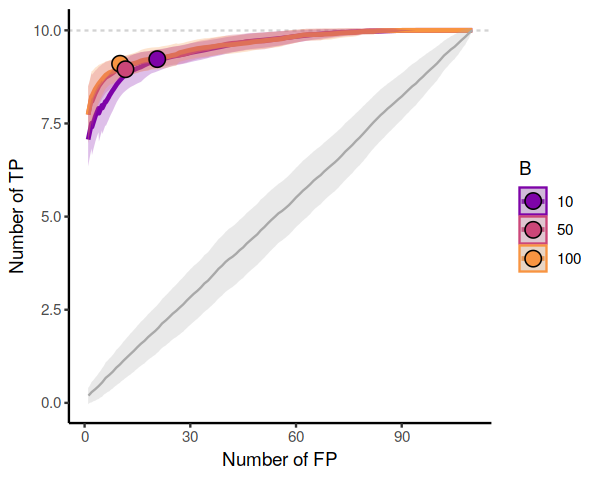

In [36]:
options(repr.plot.width=5, repr.plot.height=4)
wp

# check

In [45]:
getRes <- function(f, p = NULL, true_edges){
    tmp <- qread(f)
    b <- as.numeric(str_extract(f, pattern = '(?<=B)[:digit:]+'))
        
    # get the new metrics
    quiet(pc <- stabilitySelection(tmp$resamp, alpha_error = 5, pi_thr = 0.7))
    cond <- pc$rules_summary %>% subset(inN >= 0.7*b, select = condition) %>% unlist
    
    if (length(cond) > 0 & 'edges_agg' %in% names(pc)){
            
        imp_edges <- pc$edges_agg %>% subset(condition %in% cond) %>% select(x,y, importance, n, imp)
        imp_edges$x <- str_replace(imp_edges$x, pattern = '\\_{2}.*', replacement = '')
        imp_edges$y <- str_replace(imp_edges$y, pattern = '\\_{2}.*', replacement = '')
        suppressMessages(imp_edges <- imp_edges %>% group_by(x,y) %>% summarise(importance = sum(n*imp*importance)))
        imp_edges <- asplit(as.matrix(imp_edges), MARGIN = 1)
        imp_edges <- lapply(imp_edges, sort) 
        pred_edges <- sapply(imp_edges, function(x){paste(x[-1], collapse = ' - ')}) 

        # those that should not be but are = in pred_edges but not truth
        tp <- which(sapply(pred_edges, function(x){x %in% true_edges}))
        fp <- which(sapply(pred_edges, function(x){!(x %in% true_edges)}))
        fn <- sum(sapply(true_edges, function(x){!(x %in% pred_edges)}))

        # sum of FP importances
        if(length(fp) > 0) {
            fp_imp <- sum(sapply(imp_edges[fp], function(x){as.numeric(x['importance'])}))
        } else {fp_imp <- 0}
        # sum of TP importances
        if(length(tp) > 0) {
            tp_imp <- sum(sapply(imp_edges[tp], function(x){as.numeric(x['importance'])}))
        } else {tp_imp <- 0}

        res <- c('p' = p, 'b'=b, 'rf_accuracy' = tmp$rf_accuracy, 'rf_kappa' = tmp$rf_kappa
                 , 'n_decisions' = length(cond)
                , 'tp_imp' = tp_imp, 'fp_imp' = fp_imp, 'tp' = length(tp), 'fp' = length(fp)
                , 'fn' = fn)
    } else {
        res <- c('p' = p, 'b'=b, 'rf_accuracy' = tmp$rf_accuracy, 'rf_kappa' = tmp$rf_kappa, 'n_decisions' = 0
                , 'tp_imp' = 0, 'fp_imp' = 0, 'tp' = 0, 'fp' = 0, 'fn' = 0)
    }
    
    message(f, ' = success!')
    
    return(res)
}

In [48]:
check <- list()
for (i in 1:length(fnames)){
    check[[i]] <- getRes(f = fnames[i], p = 0.05, true_edges = true_edges)
}

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1733_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1734_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1735_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1736_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1737_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1738_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1739_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1740_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1741_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1742_p0_n1000.qs = success!

/ebio/abt3_projects/

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1817_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1818_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1819_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1820_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1821_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1822_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1823_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1824_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1825_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B100_simpler/simu1826_p0_n1000.qs = success!

/ebio/abt3_projects/

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1803_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1804_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1805_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1806_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1807_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1808_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1809_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1810_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1811_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B50_simpler/simu1812_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1788_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1789_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1790_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1791_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1792_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1793_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1794_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1795_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1796_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/aruaud/Toy_p005_N1000_B10_simpler/simu1797_p0_n1000.qs = success!

/ebio/abt3_projects/temp_data/

In [56]:
check <- as.data.frame(do.call(rbind, check))

In [59]:
check <- check %>% mutate_all(as.numeric)

In [60]:
check$precision <- check$tp/(check$tp+check$fp)
check$recall <- check$tp/(check$tp+check$fn)
check$w_precision <- check$tp_imp/(check$tp_imp+check$fp_imp)

In [64]:
check[ complete.cases(check), ] %>% group_by(b) %>% summarise_all(mean) %>% #subset(b != 10) %>% 
select(rf_accuracy, rf_kappa, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,rf_kappa,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.8897200,0.7786800,19.52000,10.180000,20.730000,0.780000,125.4201,21.25651,0.3590535,0.9283030,0.8441093
0.8897200,0.7786800,14.38000,9.720000,10.680000,1.060000,567.3801,70.36407,0.5192744,0.9003788,0.8840884
0.8897475,0.7787305,13.87879,9.727273,9.808081,1.040404,1130.6331,130.13820,0.5360608,0.9020508,0.8932890


In [65]:
check[ complete.cases(check), ] %>% group_by(b) %>% summarise_all(sd) %>% #subset(b != 10) %>% 
select(rf_accuracy, rf_kappa, n_decisions, tp, fp, fn, tp_imp, fp_imp, precision, recall, w_precision) 

rf_accuracy,rf_kappa,n_decisions,tp,fp,fn,tp_imp,fp_imp,precision,recall,w_precision
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.01508366,0.03040610,3.688585,0.9574799,8.376078,0.6126610,58.66924,11.53429,0.1278311,0.05813523,0.07503780
0.01508366,0.03040610,2.729487,0.9957485,5.870453,0.5829219,272.31699,43.32687,0.1646240,0.05862320,0.06749518
0.01515791,0.03055663,2.536560,1.0183839,5.279295,0.6047295,540.63561,82.68008,0.1580389,0.06055746,0.06089332


In [66]:
check[ complete.cases(check), ] %>% count(b)

b,n
<dbl>,<int>
10,100
50,100
100,99
